In [23]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Using TensorFlow backend.


In [24]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [25]:
hist.head(5)

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2019-01-15,5209.37,5670.18,5037.76,5152.75,367.20,1914160.32
2019-01-16,5223.12,5673.87,4895.73,5209.37,267.75,1414879.94
2019-01-17,5034.56,5620.07,4719.54,5223.12,216.06,1090430.25
2019-01-18,5048.45,5618.54,4692.93,5034.56,216.33,1094130.48
2019-01-19,4998.97,5763.10,4800.99,5048.45,141.58,743532.63


In [26]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [27]:
train, test = train_test_split(hist, test_size=0.2)

In [28]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

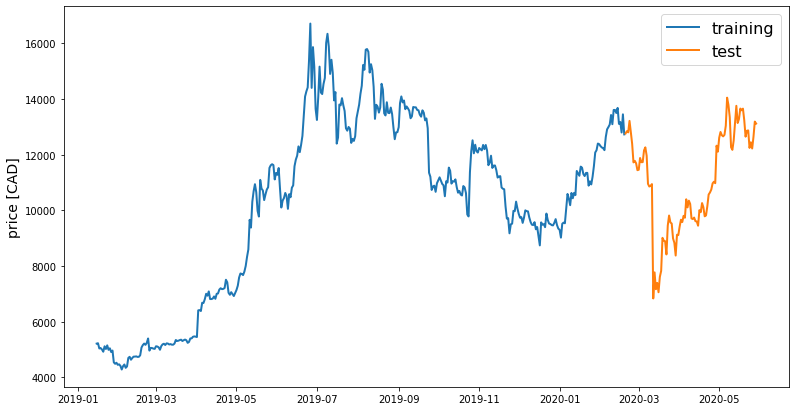

In [29]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [30]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [31]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [32]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [33]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [34]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [35]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [36]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
396/396 [==============================] - 1s 3ms/step - loss: 0.0087
Epoch 2/20
396/396 [==============================] - 0s 222us/step - loss: 0.0053
Epoch 3/20
396/396 [==============================] - 0s 265us/step - loss: 0.0058
Epoch 4/20
396/396 [==============================] - 0s 270us/step - loss: 0.0049
Epoch 5/20
396/396 [==============================] - 0s 267us/step - loss: 0.0036
Epoch 6/20
396/396 [==============================] - 0s 279us/step - loss: 0.0034
Epoch 7/20
396/396 [==============================] - 0s 260us/step - loss: 0.0045
Epoch 8/20
396/396 [==============================] - 0s 265us/step - loss: 0.0026
Epoch 9/20
396/396 [==============================] - 0s 266us/step - loss: 0.0053
Epoch 10/20
396/396 [==============================] - 0s 273us/step - loss: 0.0029
Epoch 11/20
396/396 [==============================] - 0s 279us/step - loss: 0.0070
Epoch 12/20
396/396 [==============================] - 0s 222us/step - loss: 0.0025
Epo

In [37]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.042666913071366615

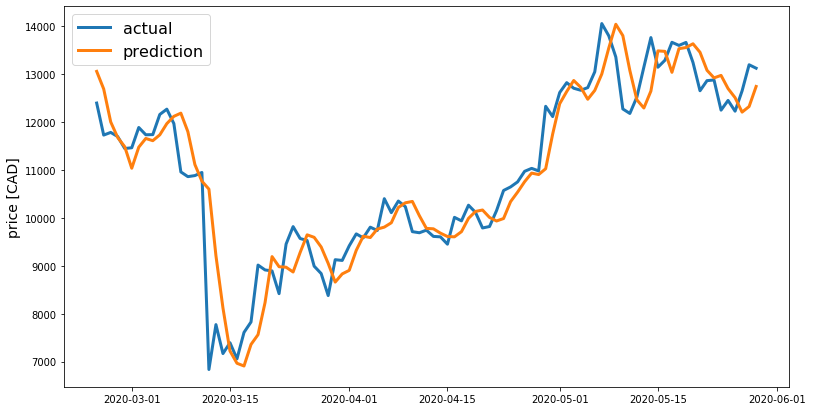

In [38]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)